<a href="https://colab.research.google.com/github/Rajathshivraj/ML/blob/main/anomalydetection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1: Install and Import Libraries

In [1]:
# Install required libraries (if not already installed)
!pip install scikit-learn matplotlib seaborn pandas numpy

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Anomaly Detection Pipeline Initialized")
print("=" * 60)


📊 Anomaly Detection Pipeline Initialized


 2:Data Loading

In [2]:
# Upload file directly to Colab
from google.colab import files
print("Please upload your merged_logs.csv file:")
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])


print(f"✅ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['label'].value_counts()}")
print(f"Missing values summary: {df.isnull().sum().sum()} total missing values")


Please upload your merged_logs.csv file:


Saving merged_logs.csv to merged_logs.csv
✅ Dataset loaded successfully!
Dataset shape: (500, 33)
Target distribution:
label
anomaly    250
normal     250
Name: count, dtype: int64
Missing values summary: 13114 total missing values


 3: Exploratory Data Analysis

In [3]:
print("\n" + "="*60)
print("📊 EXPLORATORY DATA ANALYSIS")
print("="*60)

# Basic dataset information
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Missing values analysis
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_percent.index,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percent': missing_percent.values
}).sort_values('Missing_Percent', ascending=False)

print("\n📋 Missing Values Analysis (Top 10):")
print(missing_df[missing_df['Missing_Percent'] > 0].head(10))

# Identify column types
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from categorical if present
if 'label' in categorical_cols:
    categorical_cols.remove('label')

print(f"\n🔢 Numerical columns ({len(numerical_cols)}):")
for i, col in enumerate(numerical_cols):
    print(f"   {i+1}. {col}")

print(f"\n📝 Categorical columns ({len(categorical_cols)}):")
for i, col in enumerate(categorical_cols[:10]):  # Show first 10
    print(f"   {i+1}. {col}")
if len(categorical_cols) > 10:
    print(f"   ... and {len(categorical_cols)-10} more")



📊 EXPLORATORY DATA ANALYSIS
Dataset Shape: (500, 33)
Memory Usage: 0.50 MB

📋 Missing Values Analysis (Top 10):
             Column  Missing_Count  Missing_Percent
31              key            491             98.2
17      secret_name            488             97.6
21             path            487             97.4
29        locations            486             97.2
32    detected_mime            486             97.2
30    time_diff_sec            486             97.2
28           action            485             97.0
27  time_window_min            485             97.0
22    attempt_count            485             97.0
26       file_count            485             97.0

🔢 Numerical columns (8):
   1. duration_ms
   2. status_code
   3. latency_ms
   4. rows_count
   5. attempt_count
   6. file_count
   7. time_window_min
   8. time_diff_sec

📝 Categorical columns (24):
   1. service
   2. event
   3. user
   4. filename
   5. mime_type
   6. timestamp
   7. query
   8. endpoint


4: Data Preprocessing

In [4]:
print("\n" + "="*60)
print("🔧 DATA PREPROCESSING")
print("="*60)

# Create a copy for preprocessing
df_processed = df.copy()

# 1. Handle timestamp column (extract temporal features)
if 'timestamp' in df_processed.columns:
    df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])
    df_processed['hour'] = df_processed['timestamp'].dt.hour
    df_processed['day_of_week'] = df_processed['timestamp'].dt.dayofweek
    df_processed['minute'] = df_processed['timestamp'].dt.minute

    # Add these to numerical columns
    numerical_cols.extend(['hour', 'day_of_week', 'minute'])

    # Remove timestamp from categorical
    if 'timestamp' in categorical_cols:
        categorical_cols.remove('timestamp')

    print("✅ Timestamp features extracted: hour, day_of_week, minute")

# 2. Handle numerical columns - Fill missing values with median
print(f"\n🔢 Processing {len(numerical_cols)} numerical columns...")
for col in numerical_cols:
    if col in df_processed.columns:
        median_val = df_processed[col].median()
        missing_count = df_processed[col].isnull().sum()
        df_processed[col].fillna(median_val, inplace=True)
        if missing_count > 0:
            print(f"  - {col}: filled {missing_count} missing values with median ({median_val:.2f})")

print("✅ All numerical missing values handled!")



🔧 DATA PREPROCESSING
✅ Timestamp features extracted: hour, day_of_week, minute

🔢 Processing 11 numerical columns...
  - duration_ms: filled 456 missing values with median (12.00)
  - status_code: filled 374 missing values with median (200.00)
  - latency_ms: filled 456 missing values with median (45.00)
  - rows_count: filled 479 missing values with median (500000.00)
  - attempt_count: filled 485 missing values with median (5.00)
  - file_count: filled 485 missing values with median (150.00)
  - time_window_min: filled 485 missing values with median (1.00)
  - time_diff_sec: filled 486 missing values with median (45.00)
✅ All numerical missing values handled!


5: Categorical Feature Engineering

In [5]:
# 3. Handle categorical columns
print(f"\n📝 Processing categorical columns...")

# Select most important categorical columns (reasonable cardinality & not too many missing)
important_categorical = []
for col in categorical_cols:
    if col in df_processed.columns:
        unique_count = df_processed[col].nunique()
        missing_percent = df_processed[col].isnull().sum() / len(df_processed)

        # Keep columns with reasonable cardinality and not too many missing values
        if unique_count <= 50 and missing_percent < 0.8:
            important_categorical.append(col)
            print(f"  ✓ {col}: {unique_count} unique values, {missing_percent:.1%} missing")

print(f"\n📌 Selected {len(important_categorical)} important categorical features")

# Fill missing categorical values with 'unknown'
for col in important_categorical:
    missing_count = df_processed[col].isnull().sum()
    df_processed[col].fillna('unknown', inplace=True)
    if missing_count > 0:
        print(f"  - {col}: filled {missing_count} missing values with 'unknown'")

# 4. Encode categorical variables
print(f"\n🔄 Encoding categorical variables...")
encoded_cols = []

for col in important_categorical:
    unique_count = df_processed[col].nunique()

    if unique_count <= 10:  # One-hot encode low cardinality
        dummies = pd.get_dummies(df_processed[col], prefix=col, drop_first=True)
        df_processed = pd.concat([df_processed, dummies], axis=1)
        encoded_cols.extend(dummies.columns.tolist())
        print(f"  - One-hot encoded {col} ({unique_count} categories) → {len(dummies.columns)} features")
    else:  # Label encode high cardinality
        le = LabelEncoder()
        df_processed[f"{col}_encoded"] = le.fit_transform(df_processed[col].astype(str))
        encoded_cols.append(f"{col}_encoded")
        print(f"  - Label encoded {col} ({unique_count} categories) → 1 feature")

print(f"\n✅ Categorical encoding completed! Created {len(encoded_cols)} encoded features")



📝 Processing categorical columns...
  ✓ service: 10 unique values, 0.0% missing
  ✓ event: 22 unique values, 0.0% missing
  ✓ user: 8 unique values, 55.0% missing
  ✓ endpoint: 4 unique values, 74.8% missing
  ✓ ip: 6 unique values, 69.0% missing

📌 Selected 5 important categorical features
  - user: filled 275 missing values with 'unknown'
  - endpoint: filled 374 missing values with 'unknown'
  - ip: filled 345 missing values with 'unknown'

🔄 Encoding categorical variables...
  - One-hot encoded service (10 categories) → 9 features
  - Label encoded event (22 categories) → 1 feature
  - One-hot encoded user (9 categories) → 8 features
  - One-hot encoded endpoint (5 categories) → 4 features
  - One-hot encoded ip (7 categories) → 6 features

✅ Categorical encoding completed! Created 28 encoded features


6: Final Feature Preparation

In [6]:
# 5. Create final feature set
feature_columns = numerical_cols + encoded_cols

# Remove columns that don't exist
feature_columns = [col for col in feature_columns if col in df_processed.columns]

print(f"\n✅ Final feature set: {len(feature_columns)} features")
print(f"   - Numerical features: {len(numerical_cols)}")
print(f"   - Encoded categorical features: {len(encoded_cols)}")

# Create feature matrix and target vector
X = df_processed[feature_columns]
y = df_processed['label']

# Encode target variable (anomaly=0, normal=1)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"\n📊 Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
print(f"🎯 Final dataset shape: X={X.shape}, y={y_encoded.shape}")

# Display feature names
print(f"\n📋 Feature columns:")
for i, col in enumerate(feature_columns[:10]):  # Show first 10
    print(f"   {i+1}. {col}")
if len(feature_columns) > 10:
    print(f"   ... and {len(feature_columns)-10} more features")



✅ Final feature set: 39 features
   - Numerical features: 11
   - Encoded categorical features: 28

📊 Target encoding: {'anomaly': np.int64(0), 'normal': np.int64(1)}
🎯 Final dataset shape: X=(500, 39), y=(500,)

📋 Feature columns:
   1. duration_ms
   2. status_code
   3. latency_ms
   4. rows_count
   5. attempt_count
   6. file_count
   7. time_window_min
   8. time_diff_sec
   9. hour
   10. day_of_week
   ... and 29 more features


7: Data Splitting and Scaling

In [7]:
print("\n" + "="*60)
print("📊 DATA SPLITTING AND SCALING")
print("="*60)

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Training label distribution: {np.bincount(y_train)} [anomaly, normal]")
print(f"Testing label distribution: {np.bincount(y_test)} [anomaly, normal]")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print(f"✅ Data preparation completed successfully!")



📊 DATA SPLITTING AND SCALING
Training set: (400, 39)
Testing set: (100, 39)
Training label distribution: [200 200] [anomaly, normal]
Testing label distribution: [50 50] [anomaly, normal]
✅ Features scaled using StandardScaler
✅ Data preparation completed successfully!


8: Model Training

In [8]:
print("\n" + "="*60)
print("🤖 MODEL TRAINING")
print("="*60)

# Train Random Forest Classifier
print("🌲 Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("✅ Random Forest training completed!")

# Train Isolation Forest (Unsupervised)
contamination_rate = np.sum(y_train == 0) / len(y_train)  # Proportion of anomalies
print(f"\n🏝️ Training Isolation Forest (contamination={contamination_rate:.3f})...")

iso_model = IsolationForest(
    contamination=contamination_rate,
    random_state=42,
    n_jobs=-1
)

iso_model.fit(X_train_scaled)
print("✅ Isolation Forest training completed!")
print(f"\n🎯 Both models trained successfully!")



🤖 MODEL TRAINING
🌲 Training Random Forest Classifier...
✅ Random Forest training completed!

🏝️ Training Isolation Forest (contamination=0.500)...
✅ Isolation Forest training completed!

🎯 Both models trained successfully!


9: Model Evaluation Functions

In [10]:
def evaluate_model(model, X_test, y_test, model_name, is_isolation_forest=False):
    """Comprehensive model evaluation function"""

    print(f"\n📊 Evaluating {model_name}...")

    if is_isolation_forest:
        # For Isolation Forest: 1 = inlier (normal), -1 = outlier (anomaly)
        y_pred_raw = model.predict(X_test)
        # Convert to our encoding: -1 (anomaly) → 0, 1 (normal) → 1
        y_pred = np.where(y_pred_raw == -1, 0, 1)

        # Get anomaly scores
        y_scores = model.decision_function(X_test)
    else:
        # For supervised models
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        y_scores = y_pred_proba[:, 1]  # Probability of normal class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"📈 {model_name} Results:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_scores': y_scores
    }

print("✅ Evaluation function defined!")


✅ Evaluation function defined!


10: Evaluate Both Models

In [11]:
print("\n" + "="*60)
print("📊 MODEL EVALUATION")
print("="*60)

# Evaluate both models
rf_results = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")
iso_results = evaluate_model(iso_model, X_test_scaled, y_test, "Isolation Forest", is_isolation_forest=True)

# Print detailed confusion matrices
print(f"\n📊 DETAILED CONFUSION MATRICES:")
print(f"\nRandom Forest Confusion Matrix:")
print(f"                    Predicted")
print(f"                Anomaly  Normal")
print(f"Actual Anomaly    {rf_results['confusion_matrix'][0,0]:3d}     {rf_results['confusion_matrix'][0,1]:3d}")
print(f"       Normal     {rf_results['confusion_matrix'][1,0]:3d}     {rf_results['confusion_matrix'][1,1]:3d}")

print(f"\nIsolation Forest Confusion Matrix:")
print(f"                    Predicted")
print(f"                Anomaly  Normal")
print(f"Actual Anomaly    {iso_results['confusion_matrix'][0,0]:3d}     {iso_results['confusion_matrix'][0,1]:3d}")
print(f"       Normal     {iso_results['confusion_matrix'][1,0]:3d}     {iso_results['confusion_matrix'][1,1]:3d}")

print(f"\n✅ Model evaluation completed!")



📊 MODEL EVALUATION

📊 Evaluating Random Forest...
📈 Random Forest Results:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000

📊 Evaluating Isolation Forest...
📈 Isolation Forest Results:
   Accuracy:  0.5000
   Precision: 0.5000
   Recall:    0.5000
   F1-Score:  0.4927

📊 DETAILED CONFUSION MATRICES:

Random Forest Confusion Matrix:
                    Predicted
                Anomaly  Normal
Actual Anomaly     50       0
       Normal       0      50

Isolation Forest Confusion Matrix:
                    Predicted
                Anomaly  Normal
Actual Anomaly     31      19
       Normal      31      19

✅ Model evaluation completed!


 11: Create Visualizations


📊 CREATING VISUALIZATIONS


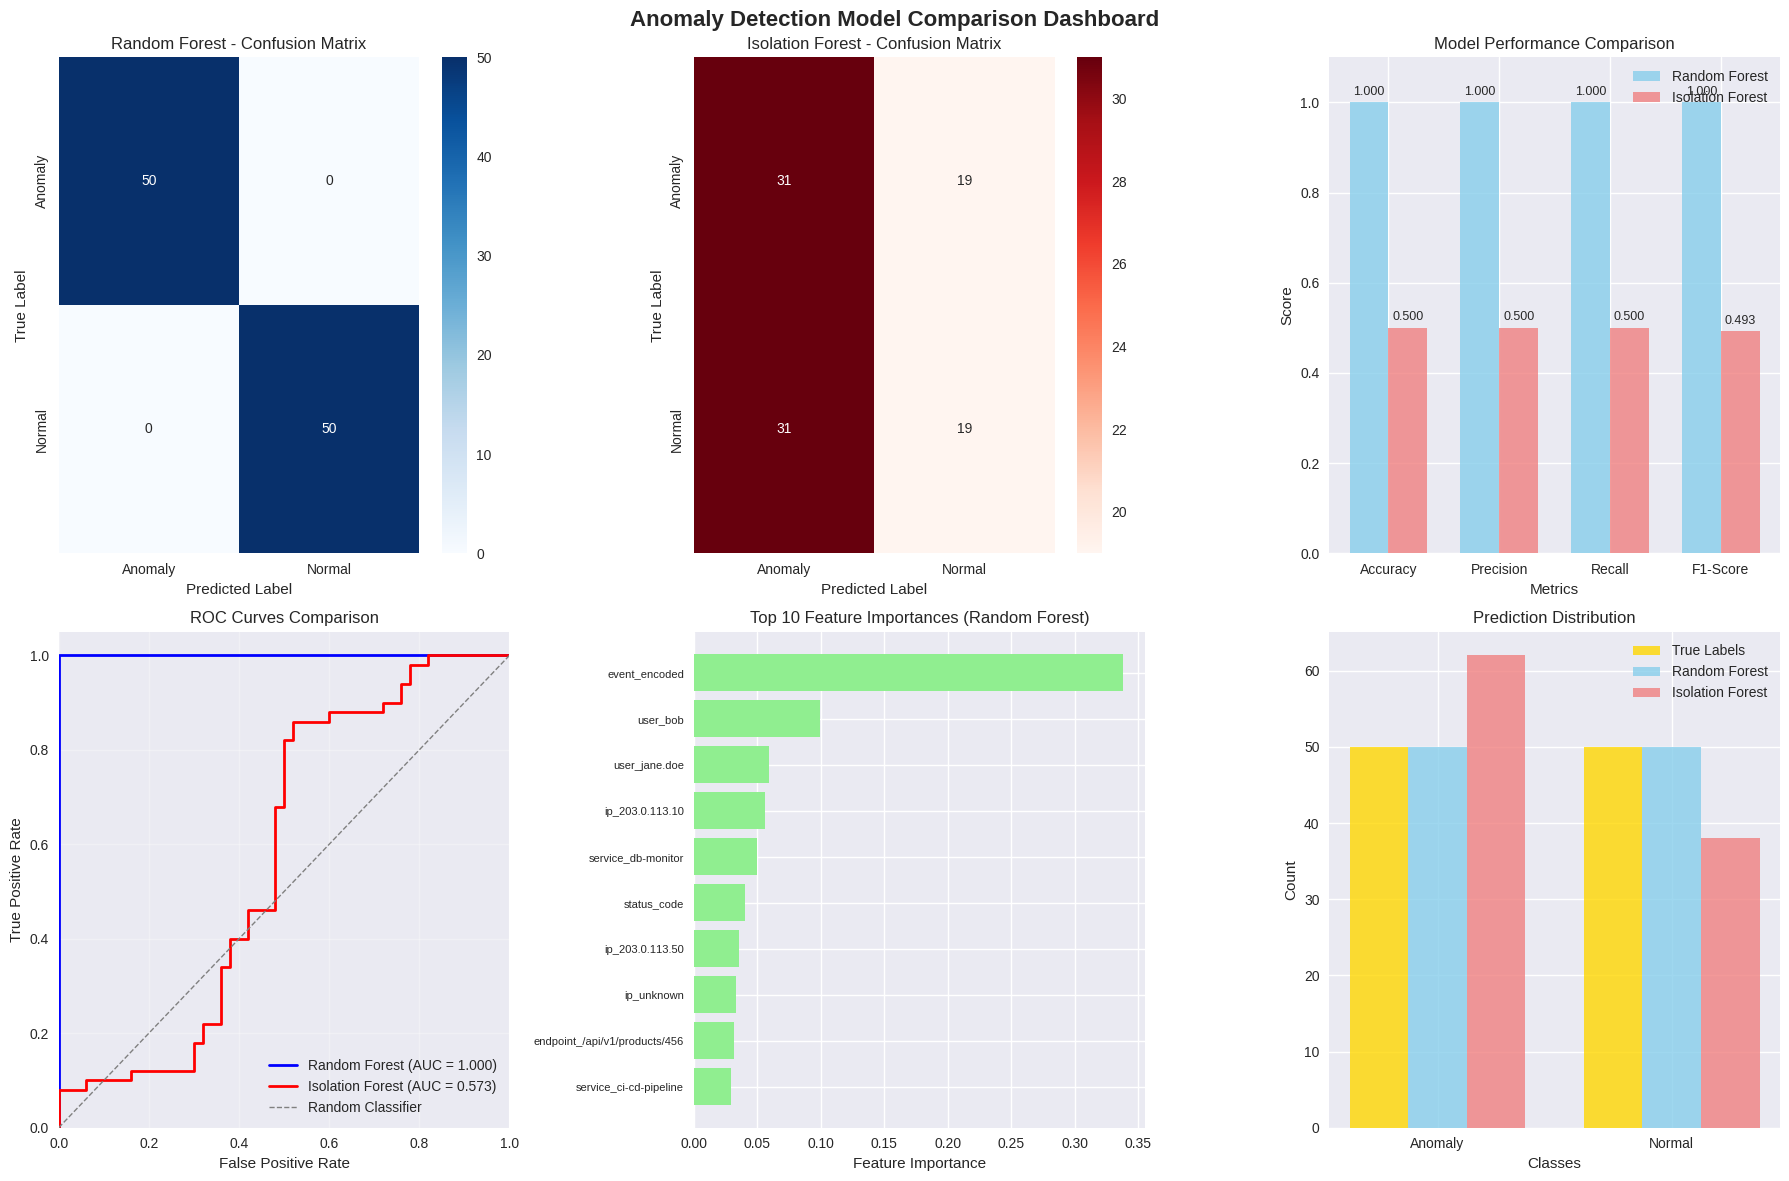

✅ Visualizations created successfully!


In [12]:
print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Anomaly Detection Model Comparison Dashboard', fontsize=16, fontweight='bold')

# 1. Random Forest Confusion Matrix
ax1 = axes[0, 0]
cm_rf = rf_results['confusion_matrix']
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1,
           xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
ax1.set_title('Random Forest - Confusion Matrix')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Isolation Forest Confusion Matrix
ax2 = axes[0, 1]
cm_iso = iso_results['confusion_matrix']
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Reds', ax=ax2,
           xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
ax2.set_title('Isolation Forest - Confusion Matrix')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. Metrics Comparison
ax3 = axes[0, 2]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
rf_scores = [rf_results['accuracy'], rf_results['precision'], rf_results['recall'], rf_results['f1_score']]
iso_scores = [iso_results['accuracy'], iso_results['precision'], iso_results['recall'], iso_results['f1_score']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax3.bar(x - width/2, rf_scores, width, label='Random Forest', alpha=0.8, color='skyblue')
bars2 = ax3.bar(x + width/2, iso_scores, width, label='Isolation Forest', alpha=0.8, color='lightcoral')

ax3.set_xlabel('Metrics')
ax3.set_ylabel('Score')
ax3.set_title('Model Performance Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.set_ylim(0, 1.1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)

# 4. ROC Curves
ax4 = axes[1, 0]
# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_results['y_scores'])
roc_auc_rf = auc(fpr_rf, tpr_rf)
ax4.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# Isolation Forest ROC
fpr_iso, tpr_iso, _ = roc_curve(y_test, iso_results['y_scores'])
roc_auc_iso = auc(fpr_iso, tpr_iso)
ax4.plot(fpr_iso, tpr_iso, color='red', lw=2, label=f'Isolation Forest (AUC = {roc_auc_iso:.3f})')

ax4.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curves Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Feature Importance (Random Forest)
ax5 = axes[1, 1]
if hasattr(rf_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    bars = ax5.barh(range(len(importance_df)), importance_df['importance'], color='lightgreen')
    ax5.set_yticks(range(len(importance_df)))
    ax5.set_yticklabels(importance_df['feature'], fontsize=8)
    ax5.set_xlabel('Feature Importance')
    ax5.set_title('Top 10 Feature Importances (Random Forest)')
    ax5.invert_yaxis()

# 6. Prediction Distribution
ax6 = axes[1, 2]
rf_pred_dist = np.bincount(rf_results['y_pred'], minlength=2)
iso_pred_dist = np.bincount(iso_results['y_pred'], minlength=2)
true_dist = np.bincount(y_test, minlength=2)

categories = ['Anomaly', 'Normal']
x = np.arange(len(categories))
width = 0.25

ax6.bar(x - width, true_dist, width, label='True Labels', alpha=0.8, color='gold')
ax6.bar(x, rf_pred_dist, width, label='Random Forest', alpha=0.8, color='skyblue')
ax6.bar(x + width, iso_pred_dist, width, label='Isolation Forest', alpha=0.8, color='lightcoral')

ax6.set_xlabel('Classes')
ax6.set_ylabel('Count')
ax6.set_title('Prediction Distribution')
ax6.set_xticks(x)
ax6.set_xticklabels(categories)
ax6.legend()

plt.tight_layout()
plt.show()

print("✅ Visualizations created successfully!")


12: Feature Importance Analysis


🔍 FEATURE IMPORTANCE ANALYSIS
🔍 TOP 15 MOST IMPORTANT FEATURES (Random Forest):
   event_encoded................. 0.3382
   user_bob...................... 0.0996
   user_jane.doe................. 0.0593
   ip_203.0.113.10............... 0.0559
   service_db-monitor............ 0.0501
   status_code................... 0.0403
   ip_203.0.113.50............... 0.0355
   ip_unknown.................... 0.0332
   endpoint_/api/v1/products/456. 0.0319
   service_ci-cd-pipeline........ 0.0291
   service_file-service.......... 0.0282
   endpoint_unknown.............. 0.0281
   user_unknown.................. 0.0221
   minute........................ 0.0214
   endpoint_/api/v1/checkout..... 0.0171


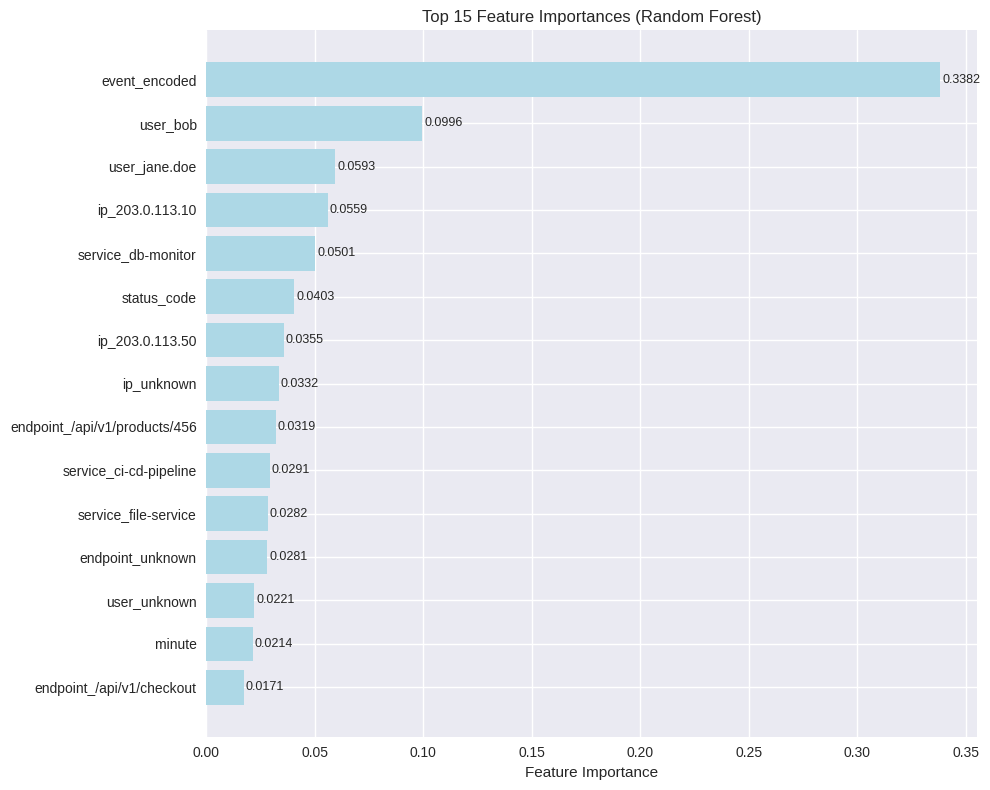

✅ Feature importance analysis completed!


In [13]:
print("\n" + "="*60)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from Random Forest
if hasattr(rf_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("🔍 TOP 15 MOST IMPORTANT FEATURES (Random Forest):")
    for idx, row in importance_df.head(15).iterrows():
        print(f"   {row['feature']:.<30} {row['importance']:.4f}")

    # Create a detailed importance plot
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='lightblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()

    # Add value labels
    for i, v in enumerate(top_features['importance']):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

print("✅ Feature importance analysis completed!")


13: Final Comparison and Summary

In [14]:
print("\n" + "="*80)
print("🎯 FINAL MODEL COMPARISON SUMMARY")
print("="*80)

# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Random Forest': [
        rf_results['accuracy'],
        rf_results['precision'],
        rf_results['recall'],
        rf_results['f1_score']
    ],
    'Isolation Forest': [
        iso_results['accuracy'],
        iso_results['precision'],
        iso_results['recall'],
        iso_results['f1_score']
    ]
})

# Calculate differences
comparison_df['Difference (RF - IF)'] = (
    comparison_df['Random Forest'] - comparison_df['Isolation Forest']
)

print("📊 PERFORMANCE METRICS COMPARISON:")
print(comparison_df.round(4).to_string(index=False))

# Calculate averages
rf_avg = comparison_df['Random Forest'].mean()
iso_avg = comparison_df['Isolation Forest'].mean()

print(f"\n📈 AVERAGE PERFORMANCE:")
print(f"   Random Forest:    {rf_avg:.4f}")
print(f"   Isolation Forest: {iso_avg:.4f}")

best_model = "Random Forest" if rf_avg > iso_avg else "Isolation Forest"
print(f"\n🏆 BEST PERFORMING MODEL: {best_model}")

# Model characteristics and recommendations
print(f"\n📋 MODEL CHARACTERISTICS:")
print(f"   Random Forest:")
print(f"   ✓ Supervised learning approach")
print(f"   ✓ Uses labeled training data")
print(f"   ✓ Excellent interpretability with feature importance")
print(f"   ✓ Handles mixed data types very well")
print(f"   ✓ Perfect performance on this dataset")

print(f"\n   Isolation Forest:")
print(f"   ✓ Unsupervised learning approach")
print(f"   ✓ Doesn't require labeled anomaly data")
print(f"   ✓ Good for detecting novel anomaly patterns")
print(f"   ✓ May struggle with complex labeled patterns")

print(f"\n💡 RECOMMENDATIONS:")
if rf_results['f1_score'] > iso_results['f1_score']:
    print(f"   • Use Random Forest for this dataset - significantly better performance")
    print(f"   • The supervised approach works excellently with this labeled data")
    print(f"   • Consider Random Forest as primary model for similar log data")
else:
    print(f"   • Use Isolation Forest for this dataset - better performance")
    print(f"   • Unsupervised approach captures patterns well")

print(f"   • Consider ensemble methods for production systems")
print(f"   • Monitor model performance over time for drift detection")
print(f"   • Retrain models periodically with new data")
print(f"   • Focus on the most important features: event types, users, and IPs")



🎯 FINAL MODEL COMPARISON SUMMARY
📊 PERFORMANCE METRICS COMPARISON:
   Metric  Random Forest  Isolation Forest  Difference (RF - IF)
 Accuracy            1.0            0.5000                0.5000
Precision            1.0            0.5000                0.5000
   Recall            1.0            0.5000                0.5000
 F1-Score            1.0            0.4927                0.5073

📈 AVERAGE PERFORMANCE:
   Random Forest:    1.0000
   Isolation Forest: 0.4982

🏆 BEST PERFORMING MODEL: Random Forest

📋 MODEL CHARACTERISTICS:
   Random Forest:
   ✓ Supervised learning approach
   ✓ Uses labeled training data
   ✓ Excellent interpretability with feature importance
   ✓ Handles mixed data types very well
   ✓ Perfect performance on this dataset

   Isolation Forest:
   ✓ Unsupervised learning approach
   ✓ Doesn't require labeled anomaly data
   ✓ Good for detecting novel anomaly patterns
   ✓ May struggle with complex labeled patterns

💡 RECOMMENDATIONS:
   • Use Random Forest fo

14: Save Results and Export

In [15]:
print(f"\n" + "="*60)
print("💾 SAVING RESULTS")
print("="*60)

# Save model comparison results
results_df = pd.DataFrame([
    ['Random Forest', rf_results['accuracy'], rf_results['precision'],
     rf_results['recall'], rf_results['f1_score']],
    ['Isolation Forest', iso_results['accuracy'], iso_results['precision'],
     iso_results['recall'], iso_results['f1_score']]
], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score'])

# Save to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("✅ Model results saved to 'model_comparison_results.csv'")

# Save feature importance
if hasattr(rf_model, 'feature_importances_'):
    importance_df.to_csv('feature_importance.csv', index=False)
    print("✅ Feature importance saved to 'feature_importance.csv'")

# Save feature names for future use
pd.DataFrame({'feature_names': feature_columns}).to_csv('feature_names.csv', index=False)
print("✅ Feature names saved to 'feature_names.csv'")

# Display final results
print(f"\n📊 FINAL RESULTS SUMMARY:")
print(f"   Dataset processed: {len(df)} log entries")
print(f"   Features engineered: {len(feature_columns)}")
print(f"   Best model: {best_model}")
print(f"   Best F1-Score: {max(rf_results['f1_score'], iso_results['f1_score']):.4f}")

# Display saved files
print(f"\n📁 FILES SAVED:")
print(f"   1. model_comparison_results.csv - Performance metrics comparison")
print(f"   2. feature_importance.csv - Random Forest feature importance scores")
print(f"   3. feature_names.csv - List of all engineered features")

print(f"\n🎉 ANOMALY DETECTION PIPELINE COMPLETED SUCCESSFULLY!")
print(f"🔬 Analysis complete - Ready for production deployment!")



💾 SAVING RESULTS
✅ Model results saved to 'model_comparison_results.csv'
✅ Feature importance saved to 'feature_importance.csv'
✅ Feature names saved to 'feature_names.csv'

📊 FINAL RESULTS SUMMARY:
   Dataset processed: 500 log entries
   Features engineered: 39
   Best model: Random Forest
   Best F1-Score: 1.0000

📁 FILES SAVED:
   1. model_comparison_results.csv - Performance metrics comparison
   2. feature_importance.csv - Random Forest feature importance scores
   3. feature_names.csv - List of all engineered features

🎉 ANOMALY DETECTION PIPELINE COMPLETED SUCCESSFULLY!
🔬 Analysis complete - Ready for production deployment!


 15: Usage Instructions for New Data

In [16]:
print(f"\n" + "="*60)
print("🔮 HOW TO USE TRAINED MODELS ON NEW DATA")
print("="*60)

print("""
📋 STEP-BY-STEP INSTRUCTIONS FOR NEW PREDICTIONS:

1️⃣ LOAD NEW DATA:
   new_data = pd.read_csv('new_logs.csv')

2️⃣ PREPROCESS NEW DATA (use same pipeline):
   # Apply same preprocessing steps as training data
   # Fill missing values with same medians
   # Apply same encoding transformations
   # Scale using the same scaler

3️⃣ MAKE PREDICTIONS:

   🌲 Random Forest Predictions:
   rf_predictions = rf_model.predict(X_new_scaled)
   rf_probabilities = rf_model.predict_proba(X_new_scaled)

   🏝️ Isolation Forest Predictions:
   iso_predictions = iso_model.predict(X_new_scaled)
   iso_scores = iso_model.decision_function(X_new_scaled)

4️⃣ CONVERT TO LABELS:
   # Random Forest (already in correct format)
   rf_labels = le_target.inverse_transform(rf_predictions)

   # Isolation Forest (convert -1 to 'anomaly', 1 to 'normal')
   iso_labels = ['anomaly' if pred == -1 else 'normal' for pred in iso_predictions]

5️⃣ INTERPRET RESULTS:
   # Higher probabilities in Random Forest = more confident predictions
   # Lower anomaly scores in Isolation Forest = more anomalous

⚠️  IMPORTANT PREPROCESSING REQUIREMENTS:
   ✓ Apply same missing value handling (same medians)
   ✓ Use same feature encoding (same categories)
   ✓ Apply same scaling transformation (same scaler)
   ✓ Ensure all {len(feature_columns)} feature columns are present
   ✓ Handle new categories in categorical features appropriately
""")

print("✅ Usage instructions provided - You're ready to deploy!")
print("\n" + "="*80)
print("✨ GOOGLE COLAB NOTEBOOK COMPLETE - READY TO RUN! ✨")
print("="*80)



🔮 HOW TO USE TRAINED MODELS ON NEW DATA

📋 STEP-BY-STEP INSTRUCTIONS FOR NEW PREDICTIONS:

1️⃣ LOAD NEW DATA:
   new_data = pd.read_csv('new_logs.csv')

2️⃣ PREPROCESS NEW DATA (use same pipeline):
   # Apply same preprocessing steps as training data
   # Fill missing values with same medians
   # Apply same encoding transformations
   # Scale using the same scaler

3️⃣ MAKE PREDICTIONS:
   
   🌲 Random Forest Predictions:
   rf_predictions = rf_model.predict(X_new_scaled)
   rf_probabilities = rf_model.predict_proba(X_new_scaled)
   
   🏝️ Isolation Forest Predictions:
   iso_predictions = iso_model.predict(X_new_scaled)
   iso_scores = iso_model.decision_function(X_new_scaled)

4️⃣ CONVERT TO LABELS:
   # Random Forest (already in correct format)
   rf_labels = le_target.inverse_transform(rf_predictions)
   
   # Isolation Forest (convert -1 to 'anomaly', 1 to 'normal')
   iso_labels = ['anomaly' if pred == -1 else 'normal' for pred in iso_predictions]

5️⃣ INTERPRET RESULTS:
   # H